# Měření BMI pomocí hloubkového senzoru
Tento úkol je zaměřen na využití dat z hloubkového senzoru - konkrétně ze senzoru **Microsoft Kinect**. Kinect je starší druh hloubkového senzoru, který umožňuje získávat hloubkové mapy v rozlišení až 640 × 480 pixelů. V každém pixelu je uložena hodnota vzdálenosti od senzoru v jednotkách mm. 

![](images/kinect_view.png)

Firmware uvnitř senzoru dále umožňuje automaticky detekovat osoby a aproximovat je tzv. skeletonem. **Skeleton** je objekt, který je definován ve své jednodušší variantě 20 body těla. K automatické detekci osoby a vytvoření skeletonu je zapotřebí kalibraovat senzor pomocí utvoření tzv. "[**psi pózy**](https://www.google.cz/search?biw=1848&bih=978&tbm=isch&sa=1&ei=WO8DXIedG6iMrwT7qry4AQ&q=psi+pose&oq=psi+pose&gs_l=img.3...0.0..8771...0.0..0.0.0.......1......gws-wiz-img.Ak1KqQmBEao)" (podle řečkého písmene &Psi;). Body jsou vidět na následujícím obrázku.

![](images/kinect_joint_points.png)

## Citace
[1] VELARDO, Carmelo a Jean-Luc DUGELAY. Weight estimation from visual body appearance. In: *2010 Fourth IEEE International Conference on Biometrics: Theory, Applications and Systems (BTAS)* [online]. IEEE, 2010, 2010, s. 1-6 [cit. 2018-12-02]. DOI: 10.1109/BTAS.2010.5634540. ISBN 978-1-4244-7581-0. Dostupné z: http://ieeexplore.ieee.org/document/5634540/ 

[2] PROKOPENKO, Stan. Human Figure Proportions - Average Figures - Dr. Paul Richer. *Proko - How to Draw*. [online]. 18.11.2013 [cit. 2015-05-10]. Dostupné z: http://www.proko.com/human-figure-proportions-average-richer/

### Import knihoven a konfigurace

In [ ]:
from improutils import *
import json
import numpy as np
import cv2
from pprint import pprint
from math import pi
import itertools

# spustí pomocné funkce z vedlejšího notebooku
%run help_functions.py

/shared-libs/python3.8/py/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='premium'>Prémiová funkce</a>

In [ ]:
def measure_distances_using_impro(image, contour, specified_points, measured_joints_pairs):
    '''???'''
    # Lengts of line segments to draw
    # ... it's highly sensitive to the size of body part
    dxs = [12, 12, 15, 40]
    
    # ???
    just_contour = np.zeros_like(image)
    just_contour = draw_contour(just_contour, contour)

    conts_with_norm_lines = np.copy(just_contour)
    
    # ???
    dists = []
    for i, point in enumerate(specified_points):
        p1 = measured_joints_pairs[i][0]
        p2 = measured_joints_pairs[i][1]
        
        # ???
        norm_lines = np.zeros_like(just_contour)
        norm_lines = draw_norm_line_segment_in_point(p1, p2, point, dxs[i], norm_lines) ###

        # ???
        conts_with_norm_lines = cv2.bitwise_or(conts_with_norm_lines, norm_lines)

        # ???
        im = cv2.bitwise_and(just_contour, norm_lines)
        idx = np.transpose(np.nonzero(im.T))

        # ???
        for j in range(0, len(idx)-1):
            dist = distance_cm(idx[j], idx[j+1], k)

            # ???
            if dist > 2 * k:
                dists.append(dist)

                # ???
                cv2.circle(conts_with_norm_lines, tuple(idx[j].T), 3, 80, -1)
                cv2.circle(conts_with_norm_lines, tuple(idx[j+1].T), 3, 80, -1)
                break
    

    assert len(dists) == 4, 'You don\'t have enough points for measure distances. You probably chose RIGHT arm, hand, etc. Try choosing left ones.'

    # ???
    plot_images(conts_with_norm_lines)

    # ???
    return dists[0], dists[1], dists[2], dists[3]

### Použitelné funkce
Seznamte se a na příslušném místě použijte!

In [ ]:
def distance_cm(p1, p2, k):
    '''Distance between two points multiplied by k'''
    return np.linalg.norm(np.array(p1) - np.array(p2)) * k

def point_in_distance(p1, p2, frac):
    '''Creates point in specific distance (fraction) between two points'''
    assert type(p1) is type(tuple()), 'Bod p1 není TUPLE!'
    assert type(p2) is type(tuple()), 'Bod p2 není TUPLE!'
    
    # Get the top point.
    if p1[1] < p2[1]:
        top = p1
        bottom = p2
    else:
        top = p2
        bottom = p1

    # Get the vector from the top to the bottom point.
    dx = bottom[0] - top[0]
    dy = bottom[1] - top[1]

    # Add the vector multiplied by the fraction to get the desired point.
    p_new_x = top[0] + (dx * frac)
    p_new_y = top[1] + (dy * frac)

    # Return result
    return (p_new_x, p_new_y)

def recount_joints(meta, crop_tl):
    '''Recounts joints coordinates if you crop the default image and returns new meta dict.'''
    meta_new = dict()
    for key in meta.keys():
        x = meta[key][0] - crop_tl[0]
        y = meta[key][1] - crop_tl[1]
        meta_new[key] = np.array((x, y))
    
    return meta_new

---

## Úkol

K výpočtu [body mass indexu (BMI)](https://cs.wikipedia.org/wiki/Index_t%C4%9Blesn%C3%A9_hmotnosti) jsou k dispozici nasnímaná data hloubkové mapy a metadata. Výpočet pro odhad hmotnosti vychází z publikace [1]. 

Za úkol je možné získat až **7 bodů** a až **2 prémiové**.

---

K výpočtu BMI bude zapotřebí změřit celkem 7 údajů. Údaje jsou přehledně zobrazeny v <a id='tab'>tabulce</a> na následujícím obrázku [1]. 

![](images/body_measurements.png)

#### 1) Načtěte data
Načtěte data hloubkové mapy ve formátu `uint16` a k tomu metadata ve formátu `json`. Metadata obsahují souřadnice bodů pro všech 20 bodů skeletonu z hloubkové mapy a převodní konstantu `k` pro přepočet vzdáleností z pixelů na cm. Uložte si konstantu zvlášť a souřadnice bodů také.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

{'ankle_left': array([414, 349]),
 'ankle_right': array([352, 349]),
 'elbow_left': array([431, 173]),
 'elbow_right': array([325, 170]),
 'foot_left': array([414, 360]),
 'foot_right': array([351, 359]),
 'hand_left': array([467, 218]),
 'hand_right': array([286, 213]),
 'head': array([379,  77]),
 'hip_center': array([377, 188]),
 'hip_left': array([391, 201]),
 'hip_right': array([364, 201]),
 'knee_left': array([404, 285]),
 'knee_right': array([358, 285]),
 'shoulder_center': array([376, 109]),
 'shoulder_left': array([407, 129]),
 'shoulder_right': array([350, 127]),
 'spine': array([378, 177]),
 'wrist_left': array([459, 207]),
 'wrist_right': array([294, 202])}


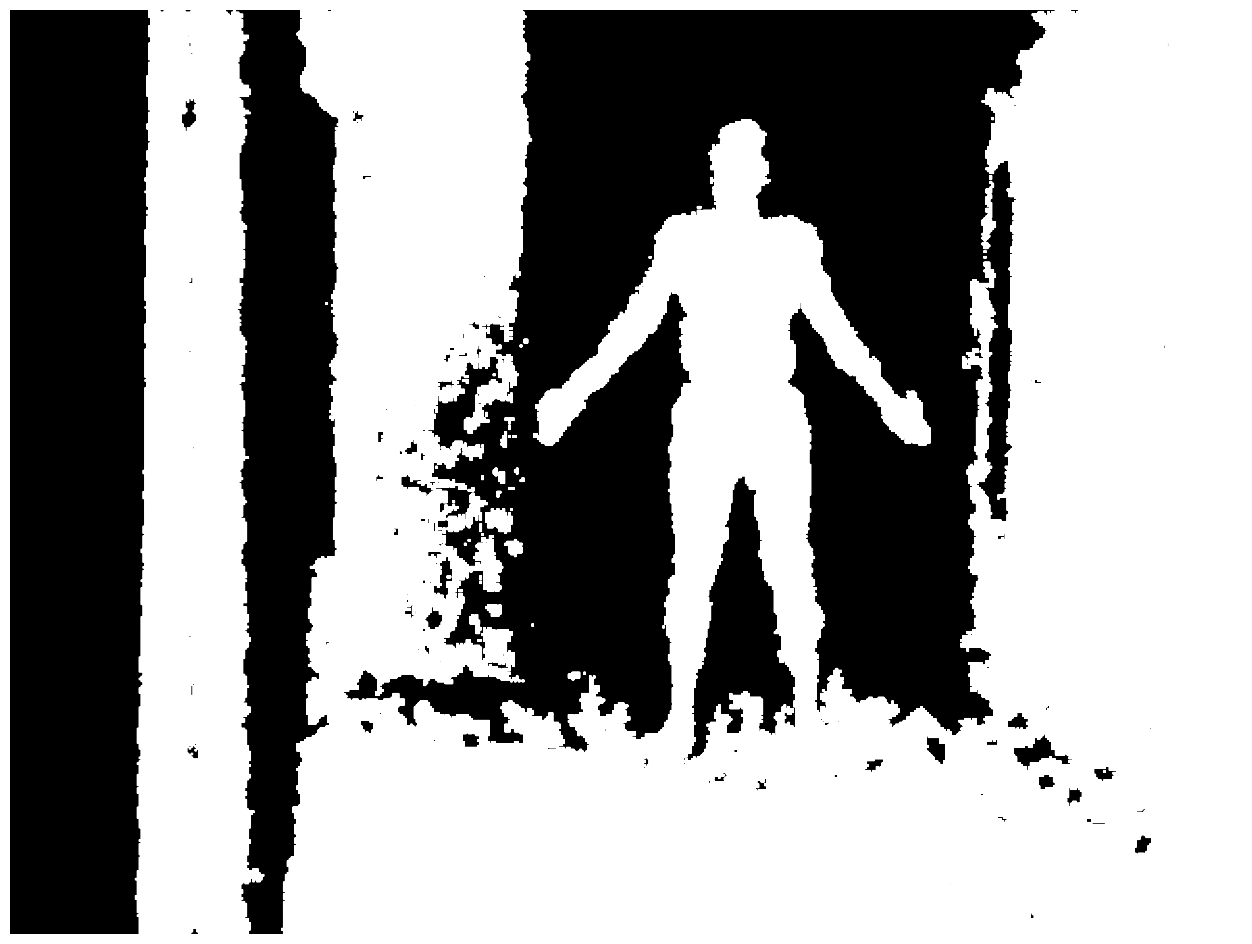

In [ ]:
# Name
name = 'data/data.png'

# Image open
depth = cv2.imread(name, cv2.IMREAD_ANYDEPTH)
plot_images(depth)

# Meta data load
with open('data/data.json') as f: ###
    meta = json.load(f)

# Constant extraction
k = meta.pop('k') ###

# Převod souřadnic na numpy array
for x in meta.keys():
    meta[x] = np.array(meta[x])

pprint(meta)

#### 2) Zobrazte skeleton
Využijte metadata skeletonu a **zobrazte body skeletonu** na snímku hloubkové mapy. Zobrazte také **spoje bodů skeletonu** podle obrázku výše. Bude se hodit funkce, která je schopna vrátit **dvojice klíčů** ze slovníku `meta` pro body skeletonu, které jsou vedle sebe.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [ ]:
# Funkce vracející dvojice sousedních bodů skeletonu
def skeleton_tuples(num=19):
    joints = list()
    joints.append(['head', 'shoulder_center'])

    joints.append(['hand_right', 'wrist_right'])
    joints.append(['wrist_right', 'elbow_right'])
    joints.append(['elbow_right', 'shoulder_right'])
    joints.append(['shoulder_right', 'shoulder_center'])

    joints.append(['hand_left', 'wrist_left'])
    joints.append(['wrist_left', 'elbow_left'])
    joints.append(['elbow_left', 'shoulder_left'])
    joints.append(['shoulder_left', 'shoulder_center'])

    joints.append(['shoulder_center', 'spine'])
    joints.append(['spine', 'hip_center'])

    joints.append(['hip_center', 'hip_right'])
    joints.append(['hip_right', 'knee_right'])
    joints.append(['knee_right', 'ankle_right'])
    joints.append(['ankle_right', 'foot_right'])

    joints.append(['hip_center', 'hip_left'])
    joints.append(['hip_left', 'knee_left'])
    joints.append(['knee_left', 'ankle_left'])
    joints.append(['ankle_left', 'foot_left'])
    
    return joints[0:num]

In [ ]:
# Funkce vykreslující kostru do obrázku
def draw_joints(depth_, meta_):
    depth_draw = depth_.copy()
    image_rgb = cv2.cvtColor(depth_draw, cv2.COLOR_GRAY2RGB)

    # Draw all joints as circles
    for pt in meta_.values():
        cv2.circle(image_rgb, pt, 5, (0, 0, 255), -1)

    # Draw all lines
    for start, end in skeleton_tuples():
        cv2.line(image_rgb, meta_[start], meta_[end], (0, 0, 255), 2)
        
    plot_images(image_rgb)

Vykreslení kostry do obrázku.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


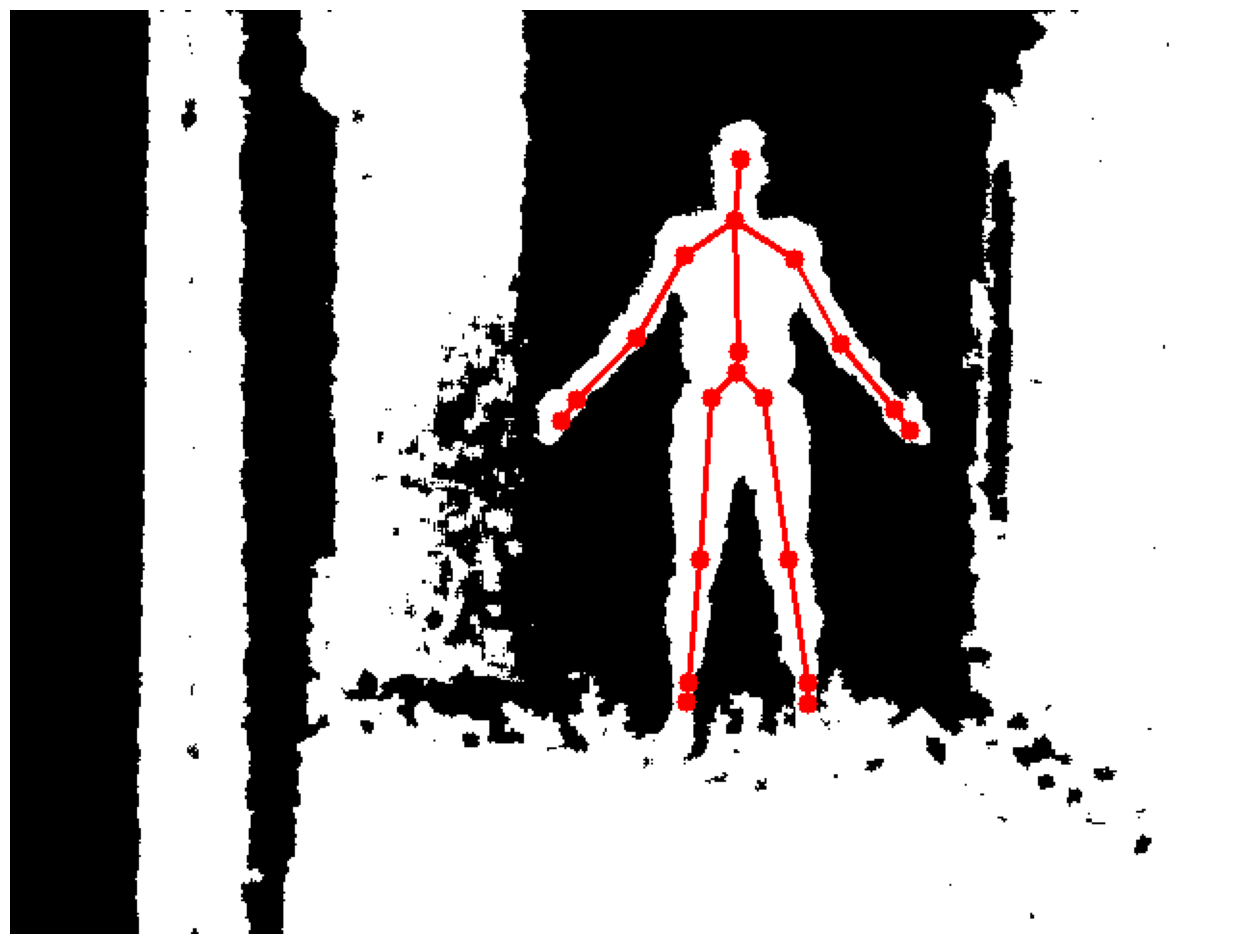

In [ ]:
draw_joints(depth, meta)

#### 3) Změřte výšku osoby `f1`
S pomocí bodů skeletonu změřte výšku osoby. Vzdálenost mezi bodem `head` a vrškem hlavy aproximujte jako 1/14 změřené výšky [2]. Měřte výšku osoby v cm! Hodnotu výšky uložte do proměnné `f1`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [ ]:
# Hlava v kostře
head = meta['head']

# Bod mezi chodidly, aby byla výška co nejkolmější na zem
between_foot = meta['foot_right'] + (meta['foot_left'] - meta['foot_right']) // 2

# přenásobení vzdálenosti mezi hlavou a "zemí" extrahovaným koeficientem 'k' a přidání 1/14 podle zadání
f1 = distance_cm(head, between_foot, k * 15 / 14)

print(f'Výška osoby je {f1:.2f} cm.')

Výška osoby je 161.92 cm.


#### 4) Segmentujte osobu z obrazu
Z hloubkové mapy segmentujte osobu. Můžete využít znalosti, že měřený subjekt dle metodiky měření stál **296 cm** od senzoru. Tloušťku osoby zvolte maximálně **50 cm**. Jako výsledek si uložte **konturu osoby**, protože se pak bude hodit dále.

Můžete si pomoci **ručním oříznutím** obrázku, avšak nezapomeňte pak **přepočítat souřadnice** bodů skeletonu! 

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


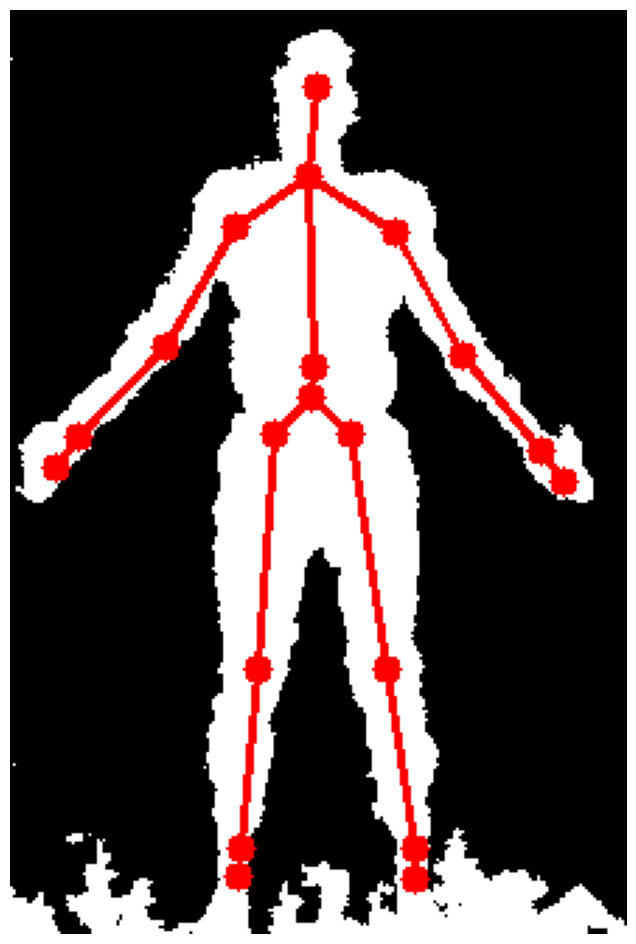

In [ ]:
image = depth.copy() # kopie
image = crop(image, 270, 50, -150, -100) # oříznutí obrázku
meta_new = recount_joints(meta, (270, 50)) # přepočítání bodů kostry
draw_joints(image, meta_new) # vykreslení oříznutého obrázku

In [ ]:
# Vykreslení kontury
def draw_mycontour(mask, cnt):
    tmp = np.zeros(mask.shape)
    for x in cnt:
        tmp[x[0][1], x[0][0]] = 255

    plot_images(tmp)

Počet: 1, typ: <class 'numpy.ndarray'>


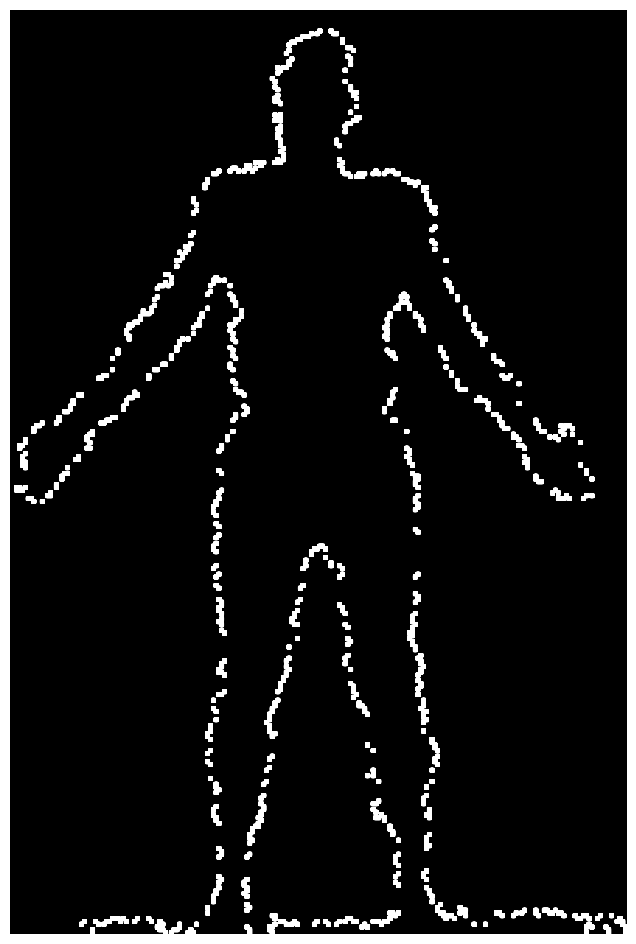

In [ ]:
# Segmentation
mask = segmentation_two_thresholds(image, 2800, 3200)

# Gets one final contour in form of np.ndarray
countour_drawn, c_count, conts = find_contours(mask, 1000, 20000)
contour = conts[0]
print(f"Počet: {c_count}, typ: {type(contour)}")
draw_mycontour(mask, contour)

#### 5) Změřte další potřebné rozměry délku stehna `f2` a délku nadloktí `f4`
Změřte další rozměry potřebné k zisku odhadu hmotnosti člověka. Potřebné rozměry jsou zobrazené v [tabulce](#tab) na následujícícm obrázku. Rozměry uložte do proměnných `f2` a `f4`.

<div style="color: blue; text-align: right">[ 0.75 bodu ]</div>

In [ ]:
v2 = meta_new['hip_right'] - meta_new['knee_right'] # vektor mezi hip_right a knee_right
v4 = meta_new['shoulder_right'] - meta_new['elbow_right'] # vektor mezi shoulder_right a elbow_right
f2 = 4 / 5 * np.linalg.norm(v2) # velikost stehna přenásobená 4/5 protože hip_right je výše než konec stehna
f4 = np.linalg.norm(v4) # velikost nadloktí

print(f2)
print(f4)

67.37121046856736
49.73932046178355


#### 6) Nalezněte body kontury pro další měření
Najděte polohy bodů pro měření šířky kontury osoby `p_3`, `p_5`, `p_7` a `p_6`. 
- Bod pro měření **lýtka** leží ve 2/3 délky mezi body skeletonu `knee` a `ankle`.
- Bod pro měření **paže** leží ve 2/3 délky mezi body skeletonu `shoulder` a `elbow`.
- Bod pro měření **stehna** leží ve 4/5 délky mezi body skeletonu `hip`a `knee`.
- Bod pro měření **pasu** leží v bodě skeletonu `hip_center`.

Dále nalezněte vždy 2 body kontury, které leží na normále (= přímce kolmé) k přímce spojující výše zmíněné body skeletonu a změřte vzdálenosti mezi nimi `d3`, `d5` a `d7`.

Pro vzdálenost `d6` se využije přímky spojující bod skeletonu `shoulder_center` s bodem `hip_center`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [ ]:
# Body ze zadání
p_3 = 2 / 3 * (meta_new['knee_left'] - meta_new['ankle_left'])
p_5 = 2 / 3 * (meta_new['elbow_left'] - meta_new['shoulder_left'])
p_7 = 4 / 5 * (meta_new['knee_left'] - meta_new['hip_left'])
p_6 = meta_new['hip_center']

points = [p_3, p_5, p_7, p_6]
measured_joint_pairs = [
[tuple(meta_new['knee_left']), tuple(meta_new['ankle_left'])],
[tuple(meta_new['shoulder_left']), tuple(meta_new['elbow_left'])],
[tuple(meta_new['hip_left']), tuple(meta_new['knee_left'])],
[tuple(meta_new['shoulder_center']), tuple(meta_new['hip_center'])]
]

# po několika hodinách epxerimentů jsem tenhle postup vzdal, nenalezly se body kontury,
# zkoušel jsem interpolací získat hustější konturu, měnit left->right,
# zkoušet opačné vektory ze kterých beru 4/5 atd.
# d3, d5, d7, d6 = measure_distances_using_impro(image, contour, points, measured_joint_pairs)

d3, d5, d7, d6 = 18 * k, 15 * k, 28 * k, 55 * k # z obrázků zkouším tipovat
print(d3, d5, d7, d6)

9.64584 8.0382 15.00464 29.4734


#### 7) Spočítejte další potřebné rozměry obvod lýtka `f3`, obvod paže `f5` a obvod stehna `f7`
Předpokládejme, že lýtko, paže i stehno lze aproximovat geometrickým útvarem válce. Z obrazu jsme získali vzdálenosti kontury osoby v potřebných bodech. Potom výpočet obvodů `f3`, `f5` a `f7` lze získat dle následujícího vzorce.

$f_i = \pi \cdot d_i$, pro $i \in \{3, 5, 7\}$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [ ]:
# Hodnoty ze zadání
f3 = np.pi * d3
f5 = np.pi * d5
f7 = np.pi * d7

print(f3)
print(f5)
print(f7)

30.30330008170257
25.252750068085476
47.138466793759555


#### 8) Spočítejte další potřebný rozměr obvod pasu `f6`
Předpokládejte, že pas nelze úplně aproximovat válcem. Tento rozměr vezmeme jako jeden hraniční. Jako druhý hraniční rozměr vezmeme dvojnásobek rozměru `d6`. Jejich průmerem pak vypočteme obvod pasu podle vzorce:

$$
f_6 = \frac{\pi \cdot d_6 + 2 \cdot d_6}{2}
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [ ]:
# Hodnota ze zadání
f6 = d6 * (np.pi + 2) / 2

print(f6)

75.77010845815671


#### 9) Spočítejte odhad hmotnosti
Dle [1] lze spočítat odhad hmotnosti člověka v kg podle následujícího vzorce.

$$
m = -122,27 + 0,48 \cdot f_1 - 0,17 \cdot f_2 + 0,52 \cdot f_3 + 0,16 \cdot f_4 + 0,77 \cdot f_5 + 0,49 \cdot f6 + 0,58 \cdot f_7
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [ ]:
# Hodnota ze zadání
m = -122.27 + 0.48 * f1 - 0.17 * f2 + 0.52 * f3 + 0.16 *  f4 + 0.77 * f5 + 0.49 * f6 + 0.58 * f7

print(f'Hmotnost osoby je {m:.2f} kg.')

Hmotnost osoby je 51.63 kg.


#### 10) Spočtěte BMI
Ze standardního vztahu vypočtěte BMI jako poměr hmotnosti $m$ v kg a výšky $h$ v m člověka.

$$
BMI = \frac{m}{h^2}
$$

<div style="color: blue; text-align: right">[ 0.5 bodu ]</div>

In [ ]:
# Hodnota ze zadání
BMI = m / ((f1 / 100) ** 2)

print(f'Výsledné BMI je {BMI:.2f} kg/m2.')

Výsledné BMI je 19.69 kg/m2.


---

#### 11) Prémium #1
Nabízím 1 prémiový bod za vysvětlení principu funkčnosti [speciální funkce](#premium) formou volného textu, ze kterého bude jasné její pochopení. 

#### 12) Prémium #2
Nabízím 1 prémiový bod za ekvivalentní funkci ke [speciální funkci](#premium), která bude založena na geometrickém zjištění protínajících se bodů kontury s body normály. Hodně je toho vyřešeno již v [pomocných funkcích](help_functions.ipynb).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a59e6efc-587e-4f5d-9bf9-800d4efce348' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>